In [2]:
%cd PortfolioOptimization/

/content/PortfolioOptimization


In [1]:
!git clone https://github.com/Chay16/PortfolioOptimization.git

fatal: destination path 'PortfolioOptimization' already exists and is not an empty directory.


In [3]:
import os
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
def get_etf_data(ETF):
    NNtype = "MLP"
    if ETF == "SPY":
        inputs_lag = cfg.SPYfeatures[NNtype]
    elif ETF == "DIA":
        inputs_lag = cfg.DIAfeatures[NNtype]
    elif ETF == "QQQ":
        inputs_lag = cfg.QQQfeatures[NNtype]

    traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
    validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
    testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
    
    features_col = []
    for i in inputs_lag:
        features_col.append("Return_" + str(i))
    target_col   = 'Target'
    

    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

    return (trainloader, trainmu, trainsigma), (validloader, validmu, validsigma), (testloader, testmu, testsigma)


In [5]:
import torch.nn as nn 

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers= 1)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    


        

In [6]:
def train_model(model, traindata, validdata, params):
  train_loss = []
  val_loss = []

  epochs = params["epochs"]
  lr = params["lr"]
  trainloader = traindata[0]
  mu_train = traindata[1]
  sigma_train = traindata[2]
  validloader = validdata[0]
  mu_val = validdata[1]
  sigma_val = validdata[2]
  
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr)

  for i in range(epochs):
      for seq, labels in trainloader:
          model.train()
          optimizer.zero_grad()

          model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))

          y_pred = model(seq.squeeze())

          single_loss = loss_function(y_pred, labels)
          single_loss.backward()
          optimizer.step()
          
      ###############################
      ###########Validation##########
      ###############################
      if i%2 == 0:
          model.eval()
          with torch.no_grad():
              loss_valid = 0
              for seq, labels in validloader:
                  y_pred = model(seq.squeeze())
                  #loss_valid += loss_function((y_pred ), (labels))
                  loss_valid += loss_function((y_pred * sigma_val) + mu_val, (labels * sigma_val) + mu_val )

              val_loss.append(loss_valid.item())
              loss_train = 0 
              for seq, labels in trainloader:
                  y_pred = model(seq.squeeze())
                  #loss_train += loss_function((y_pred), labels )

                  loss_train += loss_function((((y_pred) * sigma_train) + mu_train), (labels * sigma_train) + mu_train)
              train_loss.append(loss_train.item())
          print(f'epoch: {i:3} train_loss: {loss_train:10.10f} val_loss: {loss_valid:10.10f} ')

          
  plt.plot(train_loss)
  plt.plot(val_loss)

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test

def evaluate_model(model, testdata):
    testloader = testdata[0]
    mu = np.array(testdata[1])
    sigma = np.array(testdata[2])
    valid_targets = []
    valid_preds = []
    with torch.no_grad():
        for seq, target in testloader:
            valid_preds.append(model(seq.squeeze()))
            valid_targets += target.numpy().tolist()


     
    validRMSE = np.sqrt(mean_squared_error((valid_targets * sigma) + mu, (valid_preds*sigma) + mu))
    validMAE = mean_absolute_error((valid_targets * sigma) + mu, (valid_preds*sigma + mu))
    validMAPE = mean_absolute_percentage_error((np.array(valid_targets) * sigma) + mu , (np.array(valid_preds) * sigma) + mu)
    validTheilU = theilU((np.array(valid_targets)* sigma) + mu , (np.array(valid_preds) * sigma) + mu)

    print("MAE : {:.4f} |  MAPE  : {:.4f} |  RMSE : {:.5f} | Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
    
    plt.plot(valid_targets)
    plt.plot(valid_preds)
    plt.show()
    return {"MAE": validMAE, "RMSE": validRMSE, "MAPE": validMAPE, "Theil-U":validTheilU}

def predict(model, testdata):
    testloader = testdata[0]
    mu = testdata[1]
    sigma = testdata[2]
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for seq, target in testloader:
            predicted_labels.append(model(seq.squeeze()))
    return  (predicted_labels * np.array(sigma)) + np.array(mu)

### Generating Table 4 with baseline parameters


==========SPY==========
epoch:   0 train_loss: 0.0686238334 val_loss: 0.0121635236 
epoch:   2 train_loss: 0.0681556761 val_loss: 0.0121523626 
epoch:   4 train_loss: 0.0670396686 val_loss: 0.0121730221 
epoch:   6 train_loss: 0.0652188361 val_loss: 0.0124655003 
epoch:   8 train_loss: 0.0644848496 val_loss: 0.0125505850 
epoch:  10 train_loss: 0.0646698549 val_loss: 0.0125617767 
epoch:  12 train_loss: 1.0660048723 val_loss: 0.0995099321 
epoch:  14 train_loss: 0.0674507245 val_loss: 0.0129546113 
epoch:  16 train_loss: 0.0688119680 val_loss: 0.0132426731 
epoch:  18 train_loss: 0.0704191774 val_loss: 0.0132395402 
epoch:  20 train_loss: 0.0686998740 val_loss: 0.0135779539 
epoch:  22 train_loss: 0.0660339147 val_loss: 0.0142664295 
epoch:  24 train_loss: 0.0637220219 val_loss: 0.0145626431 
epoch:  26 train_loss: 0.0596651807 val_loss: 0.0148927914 
epoch:  28 train_loss: 0.0693549290 val_loss: 0.0149883814 
epoch:  30 train_loss: 0.0788229480 val_loss: 0.0160584860 
epoch:  32 train

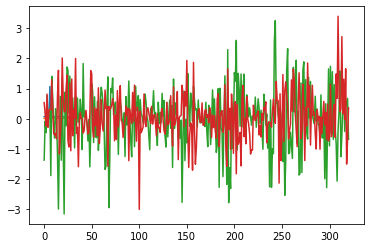

==========DIA==========
epoch:   0 train_loss: 0.0570610389 val_loss: 0.0102088647 
epoch:   2 train_loss: 0.0566834807 val_loss: 0.0102573214 
epoch:   4 train_loss: 0.0563943498 val_loss: 0.0103483908 
epoch:   6 train_loss: 0.0573525354 val_loss: 0.0107816560 
epoch:   8 train_loss: 0.0621924549 val_loss: 0.0105600990 
epoch:  10 train_loss: 0.0607396662 val_loss: 0.0117842965 
epoch:  12 train_loss: 0.0582180284 val_loss: 0.0115258507 
epoch:  14 train_loss: 0.0686247796 val_loss: 0.0136269731 
epoch:  16 train_loss: 0.0926855728 val_loss: 0.0182654634 
epoch:  18 train_loss: 0.1074275747 val_loss: 0.0217864327 
epoch:  20 train_loss: 0.0824329108 val_loss: 0.0190881900 
epoch:  22 train_loss: 0.1210120618 val_loss: 0.0250775013 
epoch:  24 train_loss: 0.1269532293 val_loss: 0.0262321848 
epoch:  26 train_loss: 0.1323559731 val_loss: 0.0261828713 
epoch:  28 train_loss: 0.1917018443 val_loss: 0.0376147293 
epoch:  30 train_loss: 0.2327652872 val_loss: 0.0430525951 
epoch:  32 train

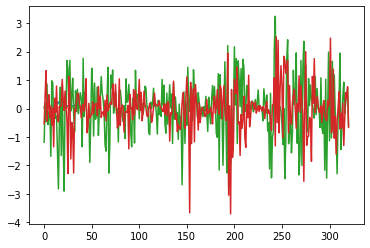

==========QQQ==========
epoch:   0 train_loss: 0.0793199539 val_loss: 0.0148868822 
epoch:   2 train_loss: 0.0791006833 val_loss: 0.0148664499 
epoch:   4 train_loss: 0.0786380991 val_loss: 0.0148406019 
epoch:   6 train_loss: 0.0790158659 val_loss: 0.0148476204 
epoch:   8 train_loss: 0.0778100193 val_loss: 0.0147860181 
epoch:  10 train_loss: 0.0779972225 val_loss: 0.0148460725 
epoch:  12 train_loss: 0.0766358078 val_loss: 0.0148666743 
epoch:  14 train_loss: 0.0753691941 val_loss: 0.0148806497 
epoch:  16 train_loss: 0.0741918907 val_loss: 0.0149136111 
epoch:  18 train_loss: 0.0708316639 val_loss: 0.0149079869 
epoch:  20 train_loss: 0.0721911490 val_loss: 0.0149748465 
epoch:  22 train_loss: 0.0747831315 val_loss: 0.0149351927 
epoch:  24 train_loss: 0.0772461742 val_loss: 0.0155553007 
epoch:  26 train_loss: 0.0697517768 val_loss: 0.0150553919 
epoch:  28 train_loss: 0.0712037981 val_loss: 0.0152133759 
epoch:  30 train_loss: 0.0703028142 val_loss: 0.0156497154 
epoch:  32 train

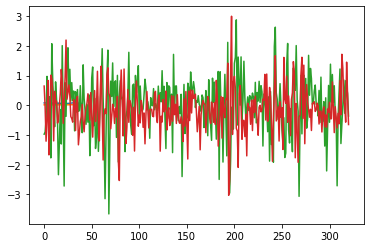

In [23]:
ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

Table4 = pd.DataFrame()

for ETF in ETF_params:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})

    print("="*10 + ETF +"="*10)
    train_data, valid_data, test_data =  get_etf_data(ETF)
    model = LSTM()
    train_model(model, train_data, valid_data, ETF_params[ETF])
    results = evaluate_model(model, test_data)
    predicted = predict(model, test_data)
    print(results)

### SAME TEST WITH DROPOUT AND L2 REGULARIZATION




==========SPY==========
epoch:   0 train_loss: 0.0686860308 val_loss: 0.0121634873 
epoch:   2 train_loss: 0.0683199391 val_loss: 0.0121476632 
epoch:   4 train_loss: 0.0673211366 val_loss: 0.0121639771 
epoch:   6 train_loss: 0.0657835826 val_loss: 0.0122851161 
epoch:   8 train_loss: 0.0650920197 val_loss: 0.0128359580 
epoch:  10 train_loss: 0.0657497942 val_loss: 0.0131290751 
epoch:  12 train_loss: 0.0681049526 val_loss: 0.0131309908 
epoch:  14 train_loss: 0.0647920966 val_loss: 0.0130503597 
epoch:  16 train_loss: 0.0661357045 val_loss: 0.0130740302 
epoch:  18 train_loss: 0.1053747833 val_loss: 0.0142929964 
epoch:  20 train_loss: 0.0871364102 val_loss: 0.0157987848 
epoch:  22 train_loss: 0.0928292498 val_loss: 0.0196687244 
epoch:  24 train_loss: 0.0882041305 val_loss: 0.0182241984 
epoch:  26 train_loss: 0.0758400708 val_loss: 0.0168979224 
epoch:  28 train_loss: 0.0830118433 val_loss: 0.0161846448 
epoch:  30 train_loss: 0.1104661152 val_loss: 0.0223303456 
epoch:  32 train

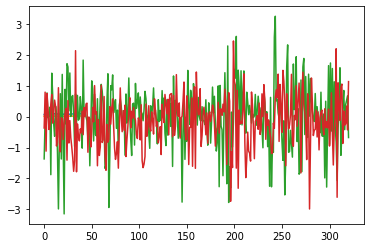

==========DIA==========
epoch:   0 train_loss: 0.0570301041 val_loss: 0.0102313925 
epoch:   2 train_loss: 0.0567722134 val_loss: 0.0102752969 
epoch:   4 train_loss: 0.0571313463 val_loss: 0.0102346195 
epoch:   6 train_loss: 0.0564087257 val_loss: 0.0103418902 
epoch:   8 train_loss: 0.0572472289 val_loss: 0.0107562058 
epoch:  10 train_loss: 0.0608743615 val_loss: 0.0111152260 
epoch:  12 train_loss: 0.0631578267 val_loss: 0.0115055954 
epoch:  14 train_loss: 0.0645637959 val_loss: 0.0125625292 
epoch:  16 train_loss: 0.0593420044 val_loss: 0.0115877297 
epoch:  18 train_loss: 0.0722630173 val_loss: 0.0112441042 
epoch:  20 train_loss: 0.0610482879 val_loss: 0.0116736265 
epoch:  22 train_loss: 0.0846001431 val_loss: 0.0108579872 
epoch:  24 train_loss: 0.0547915213 val_loss: 0.0106919026 
epoch:  26 train_loss: 0.1163239852 val_loss: 0.0105057498 
epoch:  28 train_loss: 0.0537140705 val_loss: 0.0114579266 
epoch:  30 train_loss: 0.0544524081 val_loss: 0.0108578010 
epoch:  32 train

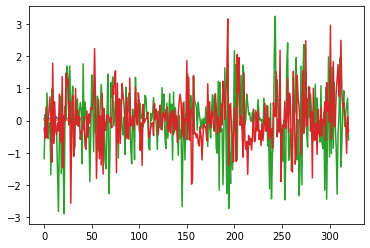

==========QQQ==========
epoch:   0 train_loss: 0.0792507306 val_loss: 0.0148794819 
epoch:   2 train_loss: 0.0790204629 val_loss: 0.0148655521 
epoch:   4 train_loss: 0.0781969875 val_loss: 0.0148044676 
epoch:   6 train_loss: 0.0782054663 val_loss: 0.0147879086 
epoch:   8 train_loss: 0.0771274269 val_loss: 0.0148190893 
epoch:  10 train_loss: 0.0755272061 val_loss: 0.0148181729 
epoch:  12 train_loss: 0.0748406127 val_loss: 0.0148638748 
epoch:  14 train_loss: 0.0745669901 val_loss: 0.0180890784 
epoch:  16 train_loss: 0.0806164443 val_loss: 0.0148977218 
epoch:  18 train_loss: 0.0773650706 val_loss: 0.0150244990 
epoch:  20 train_loss: 0.0703309998 val_loss: 0.0148804700 
epoch:  22 train_loss: 0.0822379962 val_loss: 0.0152277332 
epoch:  24 train_loss: 0.0720631108 val_loss: 0.0151840728 
epoch:  26 train_loss: 0.0719612762 val_loss: 0.0152413286 
epoch:  28 train_loss: 0.0690958649 val_loss: 0.0151084941 
epoch:  30 train_loss: 0.0710224509 val_loss: 0.0151777836 
epoch:  32 train

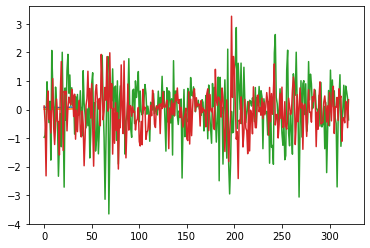

In [18]:
ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

Table4 = pd.DataFrame()

for ETF in ETF_params:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})

    print("="*10 + ETF +"="*10)
    train_data, valid_data, test_data =  get_etf_data(ETF)
    model = LSTM()
    train_model(model, train_data, valid_data, ETF_params[ETF])
    results = evaluate_model(model, test_data)
    predicted = predict(model, test_data)
    print(results)
